# Project Report

- Abhradeep


## Comparative Study of Deep Learning Architectures for Time Series Data

### Introduction

 In recent years, deep learning models have become more popular than traditional models for many machine learning tasks. Deep neural networks have been successfully applied to time series forecasting, which is an important topic in data mining. Deep neural networks are able to learn temporal dependencies in time series, which makes them effective for forecasting.

However, it can be difficult to choose the right type of deep neural network and its parameterization for a particular forecasting task. This is because there are many different architectures and hyperparameters that can be used.

### Objective:
We will perform an experimental study comparing the performance of the most popular Deep learning architectures. The comparison involves a thorough analysis of five types of deep learning models in terms of accuracy and efficiency. We evaluate the rankingsof results obtained with the proposed models under many different architecture configurations.
The models we are going to compare are: Feed Foraward Neural Network, RNN, LSTM, CNN and ResNet.The evaluation metrics we will using for this study are <b>MSE</b> and <b>RMSE</b>

In [ ]:
# Import Python libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Import PyTorch libraries

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

## Dataset

We are using time series stock data from https://www.alphavantage.co/documentation/ website using API key
This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20 years of historical data.


- Extract data points by converting json input to pandas data frame
- Adjust the index to correctly identify date as an index column
- Convert data types to understand the time series pattern from the stock data
- Generate plots to visualize time series data for a specific stock from the above processed data

In [ ]:
# Get IBM stock prices using Alpha Vantage API

endpoint = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=PWF7SB8F55JUP552"
response = requests.get(endpoint)
data = response.json()
data[:100]

In [ ]:
df_full_stock_price = pd.DataFrame(data["Time Series (Daily)"]).T.reset_index().rename(columns={"index": "dt"})
df_full_stock_price

,dt,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
0,2023-06-29,131.71,134.35,131.69,134.07,134.07,3638474,0.0000,1.0
1,2023-06-28,132.06,132.17,130.91,131.76,131.76,2753779,0.0000,1.0
2,2023-06-27,131.3,132.95,130.83,132.34,132.34,3219909,0.0000,1.0
3,2023-06-26,129.39,131.41,129.31,131.34,131.34,4845649,0.0000,1.0
4,2023-06-23,130.4,130.62,129.18,129.43,129.43,11324705,0.0000,1.0
...,...,...,...,...,...,...,...,...,...
5948,1999-11-05,92.75,92.94,90.19,90.25,48.4589055980436,13737600,0.0000,1.0
5949,1999-11-04,94.44,94.44,90.0,91.56,49.1622980227908,16697600,0.0000,1.0
5950,1999-11-03,95.87,95.94,93.5,94.37,50.6711016209128,10369100,0.0000,1.0
5951,1999-11-02,96.75,96.81,93.69,94.81,50.9073555651027,11105400,0.0000,1.0


In [ ]:
# Get only the columns - dt, adjusted close for forecasting

df_time_series = df_full_stock_price[["dt", "5. adjusted close"]]
df_time_series = df_time_series.rename(columns={"5. adjusted close": "adjusted_close"})
df_time_series["dt"] = pd.to_datetime(df_time_series["dt"])
df_time_series["adjusted_close"] = pd.to_numeric(df_time_series["adjusted_close"])
df_time_series

,dt,adjusted_close
0,2023-06-29,134.070000
1,2023-06-28,131.760000
2,2023-06-27,132.340000
3,2023-06-26,131.340000
4,2023-06-23,129.430000
...,...,...
5948,1999-11-05,48.458906
5949,1999-11-04,49.162298
5950,1999-11-03,50.671102
5951,1999-11-02,50.907356


In [ ]:
rows, columns = df_time_series.shape
rows, columns

(5953, 2)

<Axes: title={'center': 'IBM Stock Prices: 1999 to 2023'}, xlabel='Time', ylabel='Adjusted Close Price'>

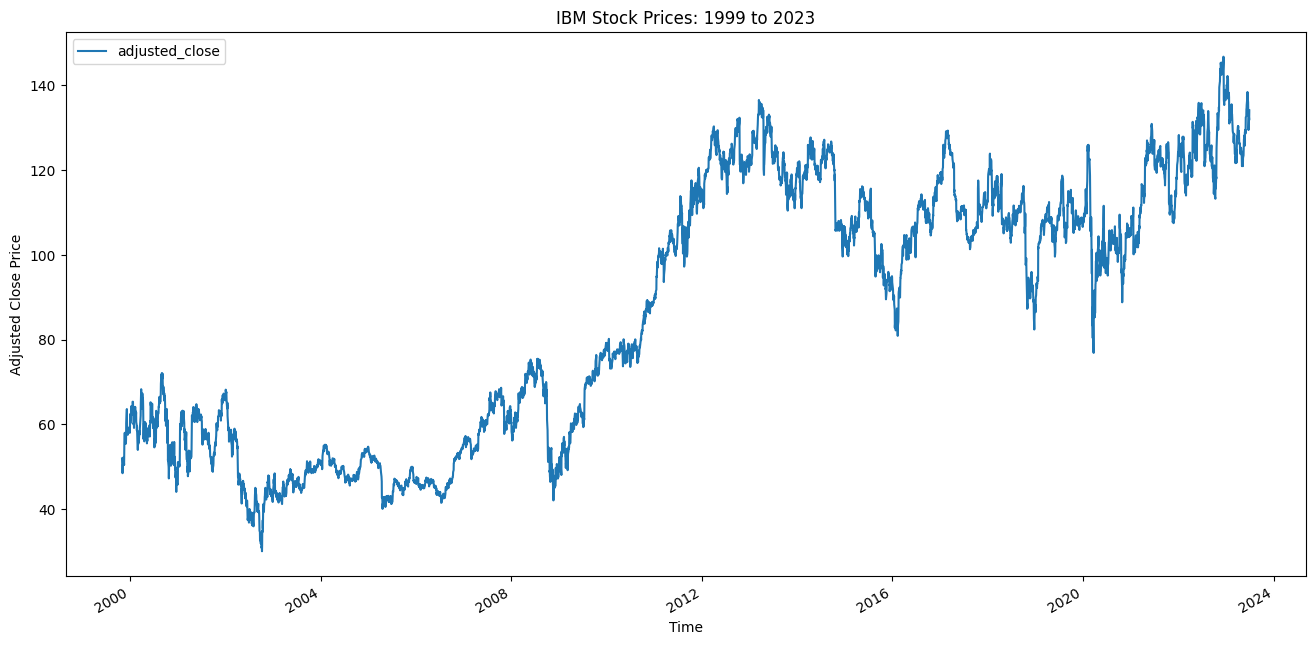

In [ ]:
df_time_series.plot(kind="line", x="dt", y="adjusted_close", figsize=(16, 8),
                    title="IBM Stock Prices: 1999 to 2023", xlabel="Time", ylabel="Adjusted Close Price")

Here, we have IBM stock prices starting from 1st November, 1999 to till date (27th June 2023), a total of 5951 days.

<h3> Data Preparation for Modeling </h3>

We will use the sliding window approach to forecast for a single day. That is, we will train the model on prices for 100 days and then forecast the price for 101st day.

In [ ]:
# Prepare features and labels to train the model on prices for 100 days

nsteps = 100
X = []
Y = []
df_adj_close = df_time_series["adjusted_close"]

for i in range(nsteps, rows):
    X.append(df_adj_close[i - nsteps :i])
    Y.append(df_adj_close[i])

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((5853, 100), (5853,))

Now, we split the datasets into train (0.8) and test sets (0.2).

In [ ]:
test_size = 500

X_train = X[:-test_size]
Y_train = Y[:-test_size]
X_test = X[-test_size:]
Y_test = Y[-test_size:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5353, 100), (5353,), (500, 100), (500,))

In [ ]:
# Scaling the data

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Convert the features and labels into tensors

Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

train_features = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(Y_test, dtype=torch.float32)

In [ ]:
train_features.shape

torch.Size([5353, 100])

<h3> Modeling and Forecasting </h3>

In [ ]:
# Attributes for training the models

learning_rate = 0.01
num_epochs = 650

In [ ]:
# Methods to fit and evaluate the model

def get_loss():
    return nn.MSELoss()

def fit_model(model, train_features, train_labels):
    # Define the loss function and optimizer
    mse_criterion = get_loss()
    adam_optim = optim.Adam(model.parameters(), lr = learning_rate)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(train_features)
        loss = mse_criterion(outputs, train_labels)

        # Backward pass and optimization
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # Loss after every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def eval_model(model, test_features, test_labels):
    # Model Evaluation
    model.eval()
    predictions = []
    with torch.no_grad():
        predictions = model(test_features)

    # Evaluate the test error
    mse_criterion = get_loss()
    mse = mse_criterion(torch.tensor(predictions), test_labels).item()
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    return predictions

def fit_eval_model(model, train_features, train_labels, test_features, test_labels):
    fit_model(model, train_features, train_labels)
    return eval_model(model, test_features, test_labels)


### 1) Feed - Forward Network

The feed-forward architecture can be used for time series data by treating the time series as a sequence of data points. The input vector x to the network would then be a vector of time series data points. The network would then learn to predict the next time series data point based on the previous data points.

The FeedForwardNet class is a neural network that has two fully connected layers. The first layer, fc1, has input_size neurons and the second layer, fc2, has output_size neurons. The forward() method of the FeedForwardNet class takes an input vector x and passes it through the two fully connected layers. The first layer applies a linear transformation to the input vector, and the second layer applies another linear transformation. The output of the second layer is the final output of the network.

The <b>relu()</b> function is an activation function that is applied to the output of the first fully connected layer. The activation function is used to introduce non-linearity into the network. Without the activation function, the network would simply be a linear function, which would not be able to learn complex relationships between the input and output variables.

The <b>criterion(MSELoss)</b> variable defines the loss function that will be used to train the network. The optimizer variable defines the optimizer that will be used to update the weights of the network.

The training_loop code iterates over the number of epochs. For each epoch, the network is forward passed on the training data. The loss between the predicted output of the network and the actual output is calculated. The weights of the network are then updated using the optimizer.

In [ ]:
# Define Feed Forward Neural Network

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X = torch.relu(self.fc1(X))
        X = self.fc2(X)
        return X

In [ ]:
# Fit and evaluate Feed Forward Neural Network

feed_forward = FeedForwardNN(nsteps, 32, 1)
ff_predictions = fit_eval_model(feed_forward, train_features, train_labels, test_features, test_labels)

Epoch [50/650], Loss: 1731.2687
Epoch [100/650], Loss: 1722.0559
Epoch [150/650], Loss: 1713.9652
Epoch [200/650], Loss: 1705.0179
Epoch [250/650], Loss: 1695.2623
Epoch [300/650], Loss: 1684.5448
Epoch [350/650], Loss: 1672.4666
Epoch [400/650], Loss: 1658.3564
Epoch [450/650], Loss: 1641.2911
Epoch [500/650], Loss: 1620.1229
Epoch [550/650], Loss: 1670.3463
Epoch [600/650], Loss: 1601.6793
Epoch [650/650], Loss: 1572.3445
Mean Squared Error (MSE): 38.5185
Root Mean Squared Error (RMSE): 6.2063


### 2) RNN

The RNN model has the following components:

- An <b>input layer</b> with input_size neurons. This layer receives the input data, which in this case is the Adjusted_Close values for a stock price.

- A <b>hidden layer</b> with hidden_size neurons. This layer is responsible for learning the temporal dependencies in the data.

- An <b>output layer</b> with output_size neurons. This layer produces the predicted Adjusted_Close values.

The RNN model works by passing the input data through the hidden layer one time step at a time. At each time step, the hidden layer updates its state based on the current input data and its previous state. The output layer then produces a prediction for the next Adjusted_Close value based on the hidden layer's state.

The model is trained by minimizing the mean squared error (MSE) between the predicted Adjusted_Close values and the actual Adjusted_Close values. The MSE is calculated for each epoch, and the model's parameters are updated using the Adam optimizer.

The training loop iterates over num_epochs. For each epoch, the model is forward passed on the training data. The loss between the predicted output of the model and the actual output is calculated. The weights of the model are then updated using the Adam optimizer. The loss is printed every 50 epochs to track the progress of the training.

The RNN architecture is a powerful approach for time series forecasting. It can learn long-term dependencies in the data, which can be important for making accurate predictions. However, RNNs can also be computationally expensive to train, and they can be difficult to train if the data is not well-behaved.

In [ ]:
X_train_rnn = df_adj_close[:-test_size]
X_test_rnn = df_adj_close[-test_size:]

X_train_rnn = X_train_rnn.astype(np.float32).values.reshape(-1, 1)
X_test_rnn = X_test_rnn.astype(np.float32).values.reshape(-1, 1)

# Scaling the data
# rnn_scaler = MinMaxScaler()
# X_train_rnn = rnn_scaler.fit_transform(X_train_rnn)
# X_test_rnn = rnn_scaler.transform(X_test_rnn)

X_train_rnn.shape, X_test_rnn.shape

((5453, 1), (500, 1))

In [ ]:
# For RNN and LSTM models, the input data should be in the format of
# (batch_size, sequence_length, input_size)

train_features_rnn = torch.tensor(X_train_rnn, dtype=torch.float32)
train_labels_rnn = torch.tensor(X_train_rnn, dtype=torch.float32)
test_features_rnn = torch.tensor(X_test_rnn, dtype=torch.float32)
test_labels_rnn = torch.tensor(X_test_rnn, dtype=torch.float32)

# Reshape the input tensors
sequence_length = 1  # Assuming a sequence length of 1
train_features_rnn = train_features_rnn.view(-1, sequence_length, 1)
train_labels_rnn = train_labels_rnn.view(-1, sequence_length, 1)
test_features_rnn = test_features_rnn.view(-1, sequence_length, 1)
test_labels_rnn = test_labels_rnn.view(-1, sequence_length, 1)

train_features_rnn.shape, train_labels_rnn.shape

(torch.Size([5453, 1, 1]), torch.Size([5453, 1, 1]))

In [ ]:
# Define the RNN model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Use the last output in the sequence
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

In [ ]:
# Fit and evaluate RNN model

rnn_model = RNNModel(1, 64, 1, num_layers=1)
rnn_predictions = fit_eval_model(rnn_model, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)

Epoch [50/650], Loss: 4438.8076
Epoch [100/650], Loss: 2130.1443
Epoch [150/650], Loss: 1256.7480
Epoch [200/650], Loss: 1003.9119
Epoch [250/650], Loss: 949.3176
Epoch [300/650], Loss: 940.6167
Epoch [350/650], Loss: 939.5993
Epoch [400/650], Loss: 939.5129
Epoch [450/650], Loss: 939.5076
Epoch [500/650], Loss: 939.5074
Epoch [550/650], Loss: 939.5075
Epoch [600/650], Loss: 939.5074
Epoch [650/650], Loss: 939.5074
Mean Squared Error (MSE): 984.1268
Root Mean Squared Error (RMSE): 31.3708


In [ ]:
# Fit and evaluate RNN model

rnn_model_1 = RNNModel(1, 32, 1, num_layers=1)
rnn_predictions_1 = fit_eval_model(rnn_model_1, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)

Epoch [50/650], Loss: 6235.5361
Epoch [100/650], Loss: 4313.6089
Epoch [150/650], Loss: 2988.5576
Epoch [200/650], Loss: 2119.7957
Epoch [250/650], Loss: 1581.5625
Epoch [300/650], Loss: 1268.1931
Epoch [350/650], Loss: 1097.4426
Epoch [400/650], Loss: 1010.6106
Epoch [450/650], Loss: 969.4656
Epoch [500/650], Loss: 951.3112
Epoch [550/650], Loss: 943.8539
Epoch [600/650], Loss: 941.0023
Epoch [650/650], Loss: 939.9874
Mean Squared Error (MSE): 942.2406
Root Mean Squared Error (RMSE): 30.6959


### 3) LSTM

The code you provided defines a Long Short-Term Memory (LSTM) architecture for time series data. The LSTM architecture has the following components:

- An <b>input layer</b> with input_size neurons. This layer receives the input data, which in this case is the Adjusted_Close values for a stock price.

- A <b>hidden layer</b> with hidden_size neurons. This layer is responsible for learning the temporal dependencies in the data.

- An <b>output layer</b> with output_size neurons. This layer produces the predicted Adjusted_Close values.

The LSTM architecture works by passing the input data through the hidden layer one time step at a time. At each time step, the hidden layer updates its state based on the current input data and its previous state. The output layer then produces a prediction for the next Adjusted_Close value based on the hidden layer's state.

The key difference between the LSTM architecture and the RNN architecture is that the LSTM architecture has a memory cell. The memory cell allows the LSTM architecture to store information about previous time steps, which can be used to make more accurate predictions.

In [ ]:
# Define LSTM model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, _ = self.lstm(x, hidden)  # Remove the 'hidden' variable from the output assignment
        out = self.fc(out[:, -1, :])  # Use the last output in the sequence
        return out

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers, batch_size, self.hidden_size))
        return hidden


In [ ]:
# Fit and evaluate LSTM model

lstm_model = LSTMModel(1, 64, 1, num_layers=1)
lstm_predictions = fit_eval_model(lstm_model, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)

Epoch [50/650], Loss: 6104.1675
Epoch [100/650], Loss: 3712.5774
Epoch [150/650], Loss: 2212.4739
Epoch [200/650], Loss: 1457.6892
Epoch [250/650], Loss: 1121.6573
Epoch [300/650], Loss: 990.0345
Epoch [350/650], Loss: 947.4102
Epoch [400/650], Loss: 940.5385
Epoch [450/650], Loss: 939.6178
Epoch [500/650], Loss: 939.5171
Epoch [550/650], Loss: 939.5081
Epoch [600/650], Loss: 939.5076
Epoch [650/650], Loss: 939.5076
Mean Squared Error (MSE): 984.1337
Root Mean Squared Error (RMSE): 31.3709


In [ ]:
# Fit and evaluate LSTM model

lstm_model_1 = LSTMModel(1, 32, 1, num_layers=1)
lstm_predictions_1 = fit_eval_model(lstm_model_1, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)

Epoch [50/650], Loss: 7382.3154
Epoch [100/650], Loss: 5927.5327
Epoch [150/650], Loss: 4757.6709
Epoch [200/650], Loss: 3720.9802
Epoch [250/650], Loss: 2931.1438
Epoch [300/650], Loss: 2307.1743
Epoch [350/650], Loss: 1835.8026
Epoch [400/650], Loss: 1521.5082
Epoch [450/650], Loss: 1276.3347
Epoch [500/650], Loss: 1123.4652
Epoch [550/650], Loss: 1039.0262
Epoch [600/650], Loss: 991.9423
Epoch [650/650], Loss: 966.2518
Mean Squared Error (MSE): 692.8917
Root Mean Squared Error (RMSE): 26.3228


### 4) CNN

The CNN architecture has the following components:

- An <b>input layer</b> with 1 neuron. This layer receives the input data, which in this case is the Adjusted_Close values for a stock price.

- A <b>convolutional layer</b> with 64 filters of size 3x1. The convolutional layer is responsible for learning the spatial dependencies in the data.

- A <b>ReLU activation layer</b> that applies the rectified linear unit function to the output of the convolutional layer.

- A <b>fully connected layer</b> with 1 neuron. This layer produces the predicted Adjusted_Close values.

The CNN architecture works by passing the input data through the convolutional layer. The convolutional layer applies a filter to the input data to extract features. The ReLU activation layer applies the rectified linear unit function to the output of the convolutional layer. The fully connected layer then takes the output of the ReLU activation layer and produces the predicted Adjusted_Close values.

The key difference between the CNN architecture and the RNN architecture is that the CNN architecture does not consider the temporal order of the data. The CNN architecture only considers the spatial relationships between the features in the data.

In the code below, the conv1 object is an instance of the nn.Conv1d class. The conv1 object has the following parameters:

- in_channels: The number of input channels.
- out_channels: The number of output channels.
- kernel_size: The size of the kernel.
- stride: The stride of the convolution.
- padding: The padding of the convolution.

In [ ]:
#Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
train_features.shape

torch.Size([5353, 100])

In [ ]:
cnn_model = CNNModel()
cnn_predictions = fit_eval_model(cnn_model, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)


Epoch [50/650], Loss: 1802.1067
Epoch [100/650], Loss: 1756.5374
Epoch [150/650], Loss: 1734.9597
Epoch [200/650], Loss: 1707.5892
Epoch [250/650], Loss: 1670.4877
Epoch [300/650], Loss: 1616.9998
Epoch [350/650], Loss: 1540.6084
Epoch [400/650], Loss: 1436.6235
Epoch [450/650], Loss: 1310.7549
Epoch [500/650], Loss: 1180.9889
Epoch [550/650], Loss: 1071.3883
Epoch [600/650], Loss: 998.1866
Epoch [650/650], Loss: 960.5577
Mean Squared Error (MSE): 660.5762
Root Mean Squared Error (RMSE): 25.7017


<h4> 5. ResNet

We are using a simplified version of the ResNet architecture for time series data. Here's an explanation of the ResNet architecture used:
1. Residual Block:
The `ResidualBlock` class represents a basic building block of the ResNet architecture. It consists of two 1D convolutional layers with a ReLU activation function. The input to the block (`x`) is passed through the first convolutional layer, then the ReLU activation function is applied. The result is passed through the second convolutional layer. The output of the block is obtained by adding the residual connection, which is the original input `x`, to the output of the second convolutional layer. Finally, the ReLU activation function is applied to the sum.
2. ResNet Model:
The `ResNet` class represents the main ResNet model. It starts with a single 1D convolutional layer (`conv1`) that takes in an input of shape `(batch_size, 1, sequence_length)` where `sequence_length` represents the length of the time series sequence. The convolutional layer has `num_channels` output channels and uses a kernel size of 3, a stride of 1, and padding of 1 to maintain the spatial dimensions.
After the initial convolutional layer, a ReLU activation function is applied (`relu`). Then, a stack of `num_blocks` residual blocks is created using the `make_residual_blocks` method. Each residual block in the stack has `num_channels` input and output channels.
The output of the residual blocks is passed through a global average pooling operation, performed using `torch.mean` along the sequence dimension. This reduces the spatial dimensions of the output to `(batch_size, num_channels)`.
Finally, the output is passed through a fully connected layer (`fc`) with `num_classes` units to produce the final predictions.
In summary, this ResNet architecture for time series data uses residual blocks to capture complex temporal patterns, followed by global average pooling and a fully connected layer for prediction.

In [ ]:
# Residual block for ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        return out

# ResNet model
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = num_channels
        self.conv1 = nn.Conv1d(1, num_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.residual_blocks = self.make_residual_blocks(num_blocks, num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def make_residual_blocks(self, num_blocks, num_channels):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualBlock(num_channels, num_channels))
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.residual_blocks(out)
        out = torch.mean(out, dim=2)  # Global average pooling
        out = self.fc(out)
        return out


In [ ]:
resnet_model = ResNet(3, 64, 1)
resnet_predictions = fit_eval_model(resnet_model, train_features_rnn, train_labels_rnn, test_features_rnn, test_labels_rnn)


Epoch [50/650], Loss: 1724.1375
Epoch [100/650], Loss: 1523.1263
Epoch [150/650], Loss: 1042.0706
Epoch [200/650], Loss: 940.5779
Epoch [250/650], Loss: 939.5719
Epoch [300/650], Loss: 939.5338
Epoch [350/650], Loss: 968.6117
Epoch [400/650], Loss: 941.0595
Epoch [450/650], Loss: 939.6060
Epoch [500/650], Loss: 939.5415
Epoch [550/650], Loss: 939.5298
Epoch [600/650], Loss: 940.0180
Epoch [650/650], Loss: 939.6253
Mean Squared Error (MSE): 980.9704
Root Mean Squared Error (RMSE): 31.3204


<h4> Plot predictions given by all models </h4>

In [ ]:
df_predictions = pd.DataFrame({
    "Time": df_time_series["dt"][-test_size:],
    "True stock prices": test_labels.tolist(),
    "Feed Forward Predictions": ff_predictions.numpy().flatten(),
    "RNN Predictions": rnn_predictions_1.numpy().flatten(),
    "LSTM Predictions": lstm_predictions_1.numpy().flatten(),
    "CNN Predictions": cnn_predictions.numpy().flatten(),
    "Resnet Predictions": resnet_predictions.numpy().flatten()
})
df_predictions.head()

,Time,True stock prices,Feed Forward Predictions,RNN Predictions,LSTM Predictions,CNN Predictions,Resnet Predictions
5453,2001-10-29,58.879505,55.377213,88.474266,87.245857,83.501846,89.147835
5454,2001-10-26,60.256363,55.965897,88.474274,87.246025,83.694885,89.139999
5455,2001-10-25,59.985325,56.126862,88.474274,87.245987,83.656883,89.141548
5456,2001-10-24,58.852402,56.065647,88.474266,87.245857,83.498055,89.147995
5457,2001-10-23,57.356293,55.743980,88.474251,87.245644,83.288292,89.156525


<Axes: >

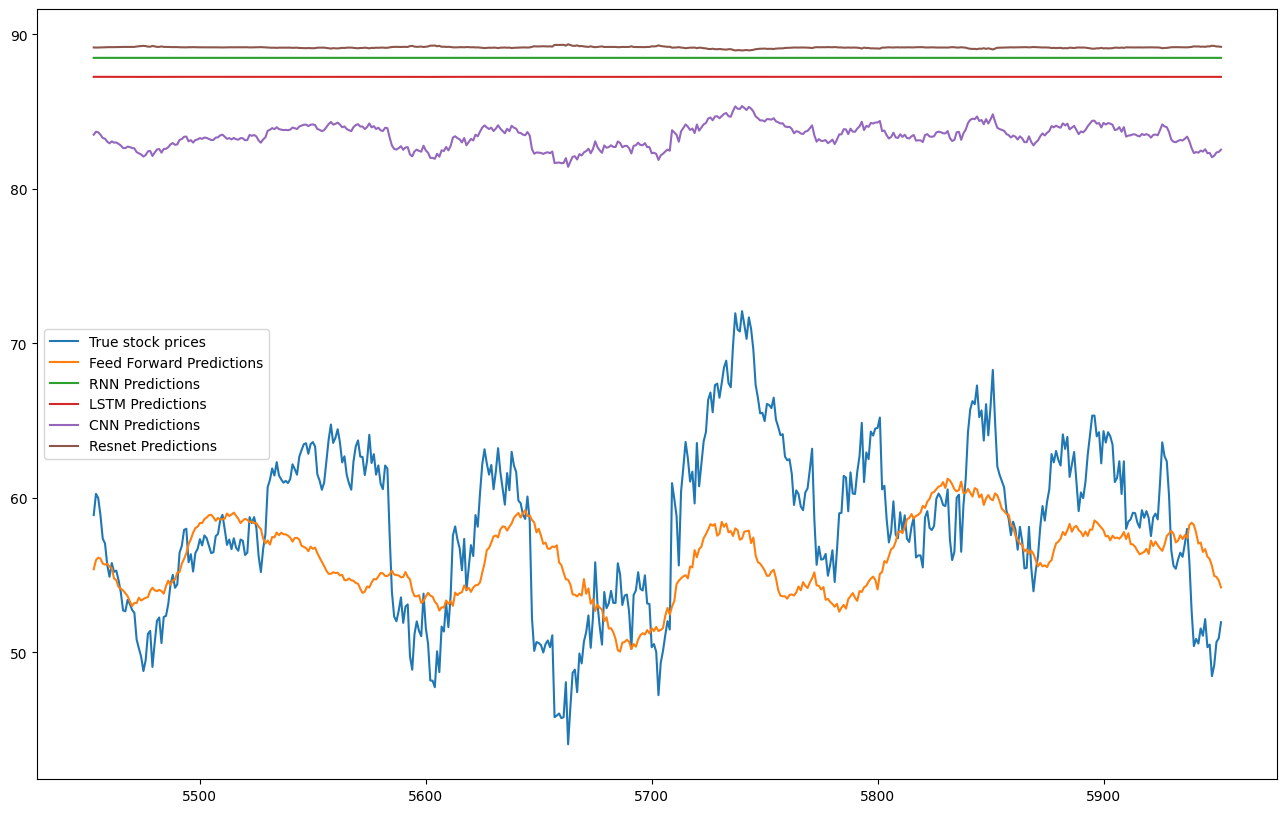

In [ ]:
df_predictions.plot.line(y=["True stock prices", "Feed Forward Predictions", "RNN Predictions",
                              "LSTM Predictions", "CNN Predictions", "Resnet Predictions"], figsize=(16, 10))